Processando evento 0...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


/tmp/ipykernel_11910/1913272706.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5 * np.log((p_total + p.z) / (p_total - p.z))
/tmp/ipykernel_11910/1913272706.py:21: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log((p_total + p.z) / (p_total - p.z))


Processando evento 1000...
Processando evento 2000...
Processando evento 3000...
Processando evento 4000...
Processando evento 5000...
Processando evento 6000...
Processando evento 7000...
Processando evento 8000...
Processando evento 9000...


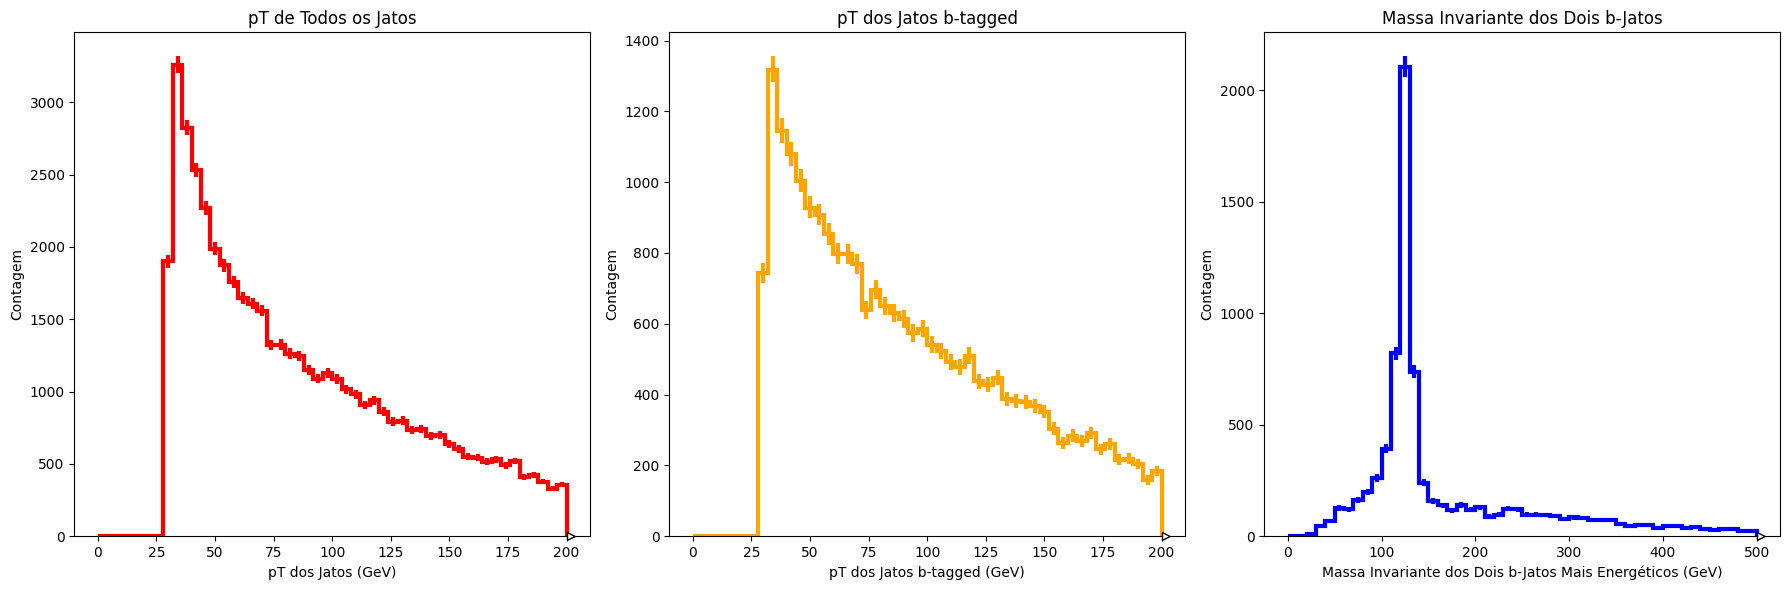

In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_invariant_mass = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para calcular a pseudorapidez (eta)
def get_eta(p):
    p_total = np.sqrt(p.x**2 + p.y**2 + p.z**2)
    if p_total == 0:
        return np.nan
    return 0.5 * np.log((p_total + p.z) / (p_total - p.z))

# Função para encontrar descendentes de quarks b
def get_b_descendants(event):
    b_descendants = []
    for particle in event.particles:
        if abs(particle.pid) == 5:  # Quarks b ou b~
            stack = [particle]
            while stack:
                current = stack.pop()
                if current.end_vertex:
                    stack.extend(current.end_vertex.particles_out)
                b_descendants.append({
                    'eta': get_eta(current.momentum),
                    'phi': np.arctan2(current.momentum.y, current.momentum.x)
                })
    return b_descendants

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, b_descendants, cone_radius=0.4):
    for b in b_descendants:
        delta_eta = jet.eta() - b['eta']
        delta_phi = np.abs(jet.phi() - b['phi'])
        if delta_phi > np.pi:
            delta_phi -= 2 * np.pi
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        if delta_r < cone_radius:
            return True
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar os eventos diretamente do arquivo
def process_hepmc_file(hepmc_file, max_events=10000):
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            if i % 1000 == 0:
                print(f"Processando evento {i}...")

            # Selecionar partículas finais
            particles = [p for p in event.particles if p.status == 1]

            # Converter partículas para FastJet
            fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]

            # Definir o algoritmo de clustering (anti-kT)
            jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)

            # Executar o clustering
            clusterer = fj.ClusterSequence(fj_particles, jet_def)
            jets = clusterer.inclusive_jets(30.0)  # pT > 30 GeV

            # Preencher histogramas de jatos
            histo_njets.fill(len(jets))
            for jet in jets:
                histo_jets_pt.fill(jet.pt())

            # Encontrar descendentes de quarks b
            b_descendants = get_b_descendants(event)

            # Identificar b-jatos e preencher histogramas
            b_jets = [jet for jet in jets if is_b_tagged(jet, b_descendants)]
            for bjet in b_jets:
                histo_bjets_pt.fill(bjet.pt())

            # Massa invariante dos dois b-jatos mais energéticos
            if len(b_jets) >= 2:
                b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)[:2]
                histo_bjets_invariant_mass.fill(invariant_mass(b_jets[0], b_jets[1]))

# Processar o arquivo HEPMC
process_hepmc_file(hepmc_file)

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    histo_jets_pt.plot(ax=ax[0], ls="-", color="red", lw=3)
    ax[0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem', title='pT de Todos os Jatos')

    histo_bjets_pt.plot(ax=ax[1], ls="-", color="orange", lw=3)
    ax[1].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem', title='pT dos Jatos b-tagged')

    histo_bjets_invariant_mass.plot(ax=ax[2], ls="-", color="blue", lw=3)
    ax[2].set(xlabel='Massa Invariante dos Dois b-Jatos Mais Energéticos (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos')

    plt.tight_layout()
    plt.show()

# Plotar os histogramas
plot_histograms()


Processando evento 0...
Processando evento 1000...
Processando evento 2000...
Processando evento 3000...
Processando evento 4000...
Processando evento 5000...
Processando evento 6000...
Processando evento 7000...
Processando evento 8000...
Processando evento 9000...


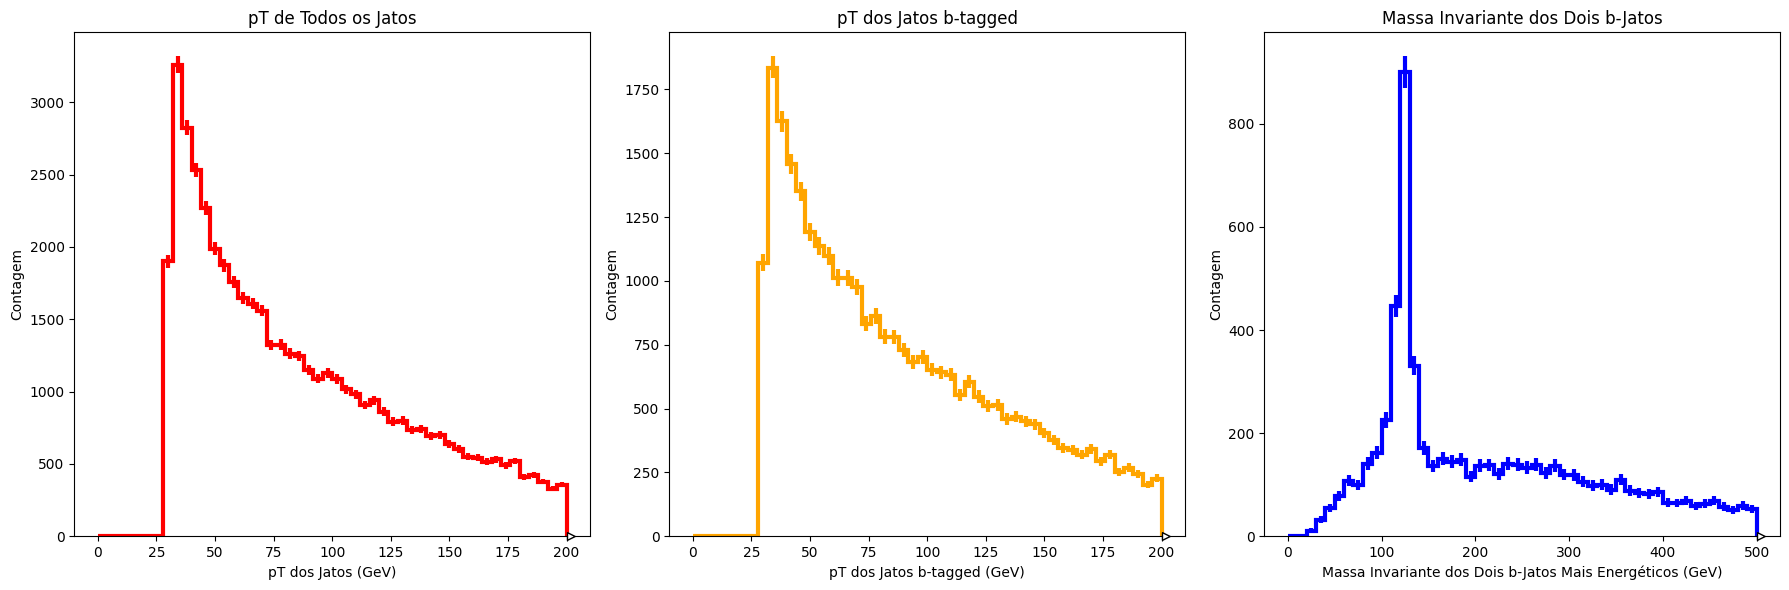

In [2]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()  # pT dos jatos b-tagged
histo_bjets_invariant_mass = hist.Hist.new.Reg(50, 0., 500.).Double()  # Massa invariante dos b-jatos

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para verificar se um jato é b-tagged com base no deslocamento do vértice secundário
def is_b_tagged(jet, particles, cone_radius=0.4):
    jet_eta, jet_phi = jet.eta(), jet.phi()
    secondary_vertex_displacement = []

    for p in particles:
        eta = get_eta(p)
        phi = np.arctan2(p.momentum.y, p.momentum.x)
        delta_eta = jet_eta - eta
        delta_phi = np.abs(jet_phi - phi)
        if delta_phi > np.pi:
            delta_phi -= 2 * np.pi
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        
        if delta_r < cone_radius and p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)

    return len(secondary_vertex_displacement) > 0 and np.mean(secondary_vertex_displacement) > 1.0

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para analisar o evento e preencher os histogramas
def analyze_event(event):
    particles = [p for p in event.particles if p.status == 1]
    fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
    
    jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
    clusterer = fj.ClusterSequence(fj_particles, jet_def)
    jets = clusterer.inclusive_jets(30.0)

    histo_njets.fill(len(jets))
    for jet in jets:
        histo_jets_pt.fill(jet.pt())
    
    b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
    for jet in b_jets:
        histo_bjets_pt.fill(jet.pt())
    
    if len(b_jets) >= 2:
        b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)[:2]
        histo_bjets_invariant_mass.fill(invariant_mass(b_jets[0], b_jets[1]))

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    histo_jets_pt.plot(ax=ax[0], ls="-", color="red", lw=3)
    ax[0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem', title='pT de Todos os Jatos')

    histo_bjets_pt.plot(ax=ax[1], ls="-", color="orange", lw=3)
    ax[1].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem', title='pT dos Jatos b-tagged')

    histo_bjets_invariant_mass.plot(ax=ax[2], ls="-", color="blue", lw=3)
    ax[2].axvline(125, color='red', linestyle='dashed', linewidth=2)
    ax[2].set(xlabel='Massa Invariante dos Dois b-Jatos Mais Energéticos (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos')

    plt.tight_layout()
    plt.show()

# Limite máximo de eventos para evitar sobrecarga
max_events = 10000

with hep.open(hepmc_file) as f:
    for ievt, event in enumerate(f):
        if ievt >= max_events:
            break
        if ievt % 1000 == 0:
            print(f"Processando evento {ievt}...")
        analyze_event(event)

# Plotar os histogramas
plot_histograms()


Processando evento 0...
Processando evento 1000...
Processando evento 2000...
Processando evento 3000...
Processando evento 4000...
Processando evento 5000...
Processando evento 6000...
Processando evento 7000...
Processando evento 8000...
Processando evento 9000...


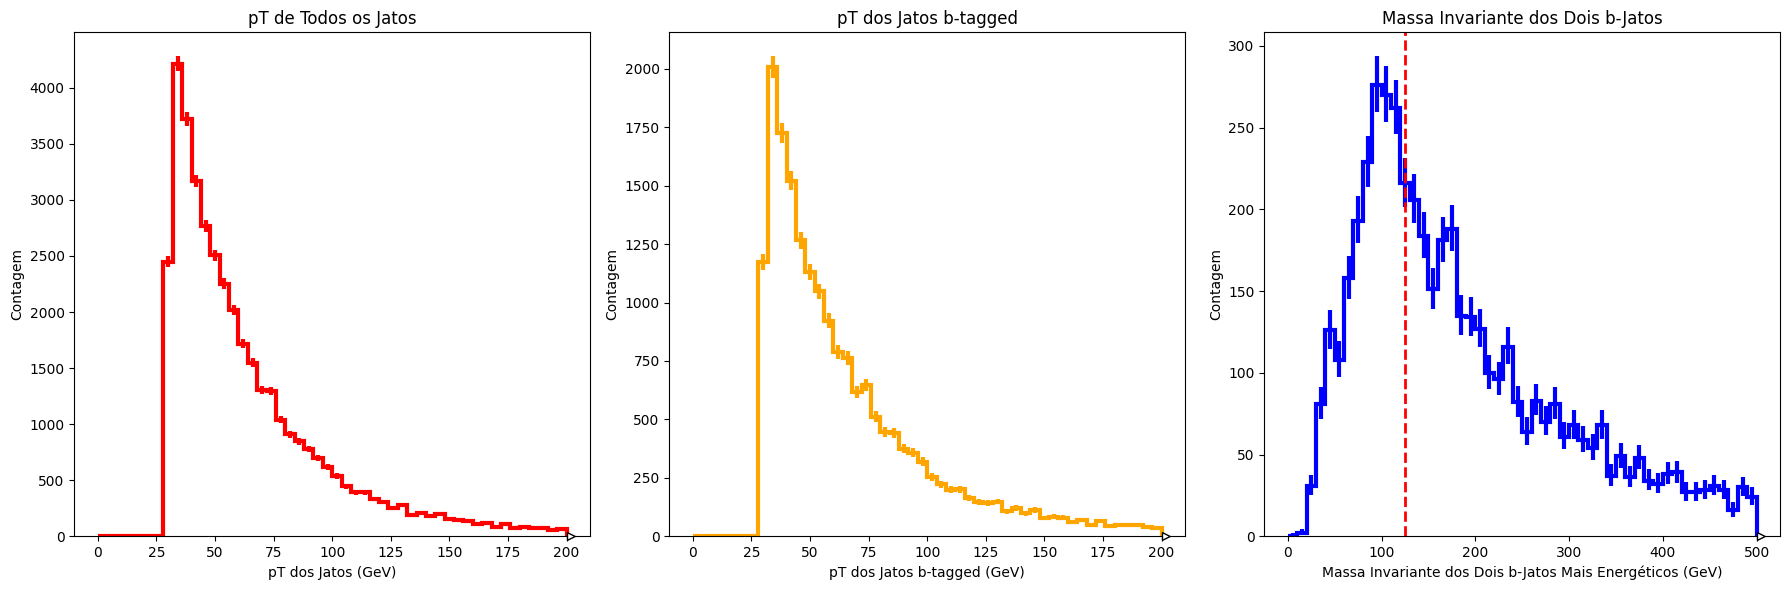

In [6]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()  # pT dos jatos b-tagged
histo_bjets_invariant_mass = hist.Hist.new.Reg(50, 0., 500.).Double()  # Massa invariante dos b-jatos

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para verificar se um jato é b-tagged com base no deslocamento do vértice secundário
def is_b_tagged(jet, particles, cone_radius=0.4):
    jet_eta, jet_phi = jet.eta(), jet.phi()
    secondary_vertex_displacement = []

    for p in particles:
        eta = get_eta(p)
        phi = np.arctan2(p.momentum.y, p.momentum.x)
        delta_eta = jet_eta - eta
        delta_phi = np.abs(jet_phi - phi)
        if delta_phi > np.pi:
            delta_phi -= 2 * np.pi
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        
        if delta_r < cone_radius and p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)

    return len(secondary_vertex_displacement) > 0 and np.mean(secondary_vertex_displacement) > 1.0

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para analisar o evento e preencher os histogramas
def analyze_event(event):
    particles = [p for p in event.particles if p.status == 1]
    fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
    
    jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
    clusterer = fj.ClusterSequence(fj_particles, jet_def)
    jets = clusterer.inclusive_jets(30.0)

    histo_njets.fill(len(jets))
    for jet in jets:
        histo_jets_pt.fill(jet.pt())
    
    b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
    for jet in b_jets:
        histo_bjets_pt.fill(jet.pt())
    
    if len(b_jets) >= 2:
        b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)[:2]
        histo_bjets_invariant_mass.fill(invariant_mass(b_jets[0], b_jets[1]))

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    histo_jets_pt.plot(ax=ax[0], ls="-", color="red", lw=3)
    ax[0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem', title='pT de Todos os Jatos')

    histo_bjets_pt.plot(ax=ax[1], ls="-", color="orange", lw=3)
    ax[1].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem', title='pT dos Jatos b-tagged')

    histo_bjets_invariant_mass.plot(ax=ax[2], ls="-", color="blue", lw=3)
    ax[2].axvline(125, color='red', linestyle='dashed', linewidth=2)
    ax[2].set(xlabel='Massa Invariante dos Dois b-Jatos Mais Energéticos (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos')

    plt.tight_layout()
    plt.show()

# Limite máximo de eventos para evitar sobrecarga
max_events = 10000

with hep.open(hepmc_file) as f:
    for ievt, event in enumerate(f):
        if ievt >= max_events:
            break
        if ievt % 1000 == 0:
            print(f"Processando evento {ievt}...")
        analyze_event(event)

# Plotar os histogramas
plot_histograms()


Processando evento 0...
Processando evento 1000...
Processando evento 2000...
Processando evento 3000...
Processando evento 4000...
Processando evento 5000...
Processando evento 6000...
Processando evento 7000...
Processando evento 8000...
Processando evento 9000...


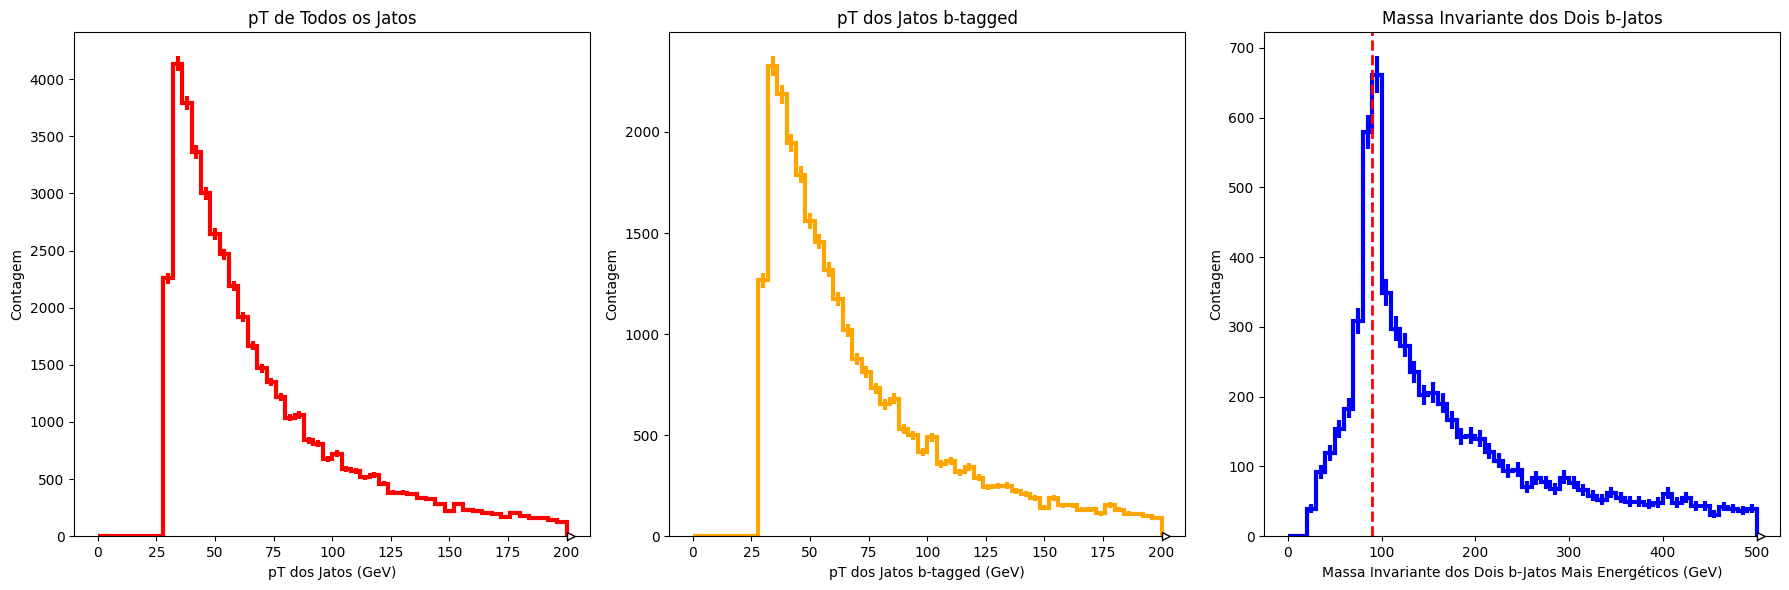

In [5]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()  # pT dos jatos b-tagged
histo_bjets_invariant_mass = hist.Hist.new.Reg(50, 0., 500.).Double()  # Massa invariante dos b-jatos

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para verificar se um jato é b-tagged com base no deslocamento do vértice secundário
def is_b_tagged(jet, particles, cone_radius=0.4):
    jet_eta, jet_phi = jet.eta(), jet.phi()
    secondary_vertex_displacement = []

    for p in particles:
        eta = get_eta(p)
        phi = np.arctan2(p.momentum.y, p.momentum.x)
        delta_eta = jet_eta - eta
        delta_phi = np.abs(jet_phi - phi)
        if delta_phi > np.pi:
            delta_phi -= 2 * np.pi
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        
        if delta_r < cone_radius and p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)

    return len(secondary_vertex_displacement) > 0 and np.mean(secondary_vertex_displacement) > 1.0

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para analisar o evento e preencher os histogramas
def analyze_event(event):
    particles = [p for p in event.particles if p.status == 1]
    fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
    
    jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
    clusterer = fj.ClusterSequence(fj_particles, jet_def)
    jets = clusterer.inclusive_jets(30.0)

    histo_njets.fill(len(jets))
    for jet in jets:
        histo_jets_pt.fill(jet.pt())
    
    b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
    for jet in b_jets:
        histo_bjets_pt.fill(jet.pt())
    
    if len(b_jets) >= 2:
        b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)[:2]
        histo_bjets_invariant_mass.fill(invariant_mass(b_jets[0], b_jets[1]))

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    histo_jets_pt.plot(ax=ax[0], ls="-", color="red", lw=3)
    ax[0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem', title='pT de Todos os Jatos')

    histo_bjets_pt.plot(ax=ax[1], ls="-", color="orange", lw=3)
    ax[1].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem', title='pT dos Jatos b-tagged')

    histo_bjets_invariant_mass.plot(ax=ax[2], ls="-", color="blue", lw=3)
    ax[2].axvline(90, color='red', linestyle='dashed', linewidth=2)
    ax[2].set(xlabel='Massa Invariante dos Dois b-Jatos Mais Energéticos (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos')

    plt.tight_layout()
    plt.show()

# Limite máximo de eventos para evitar sobrecarga
max_events = 10000

with hep.open(hepmc_file) as f:
    for ievt, event in enumerate(f):
        if ievt >= max_events:
            break
        if ievt % 1000 == 0:
            print(f"Processando evento {ievt}...")
        analyze_event(event)

# Plotar os histogramas
plot_histograms()
